In [17]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import drivers
from importlib import reload
from lib import data_management as dm
from lib.ResonatorDetector import detect_resonator

In [4]:
from datetime import datetime as dt

In [1]:
from drivers.Agilent_PNA_L import *
from drivers.Agilent_EXA import *
from drivers.KeysightAWG import *
from drivers.Keysight_DSOX2014 import *
from drivers.E8257D import MXG, EXG
from drivers.Yokogawa_GS200 import Yokogawa_GS210
from scipy.fftpack import fft, fftshift

In [6]:
def format_time_delta(delta):
    hours, remainder = divmod(delta, 3600)
    minutes, seconds = divmod(remainder, 60)
    return '%s h %s m %s s' % (int(hours), int(minutes), round(seconds, 2))

In [7]:
mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0

In [22]:
current = Yokogawa_GS210("GS210_3")
current.set_appropriate_range(10e-3)
current.set_current_limits(-9e-3,9e-3)

In [25]:
q_lo = MXG("MXG")

In [24]:
q_lo.visa_instr.close()

In [14]:
q_awg=KeysightAWG("AWG2")

In [12]:
vna = Agilent_PNA_L("PNA-L2")

In [15]:
ro_awg = KeysightAWG("AWG3")

In [2]:
dso = Keysight_DSOX2014("DSO2014")

In [9]:
if_freq = 50e6

calibrations = (dm.load_IQMX_calibration_database("TEST", -20))
ro_cal = calibrations.get(frozenset(dict(lo_power=0, ssb_power=-50, lo_frequency=7.047e9, 
                                      if_frequency=0, waveform_resolution=0.1).items()))
ro_pb = PulseBuilder(ro_cal)

calibrations = (dm.load_IQMX_calibration_database("TESTQ", -6))
q_cal = calibrations.get(frozenset(dict(lo_power=15, ssb_power=-40, lo_frequency=7.9e9+if_freq, 
                                      if_frequency=if_freq, waveform_resolution=0.1).items()))
q_pb = PulseBuilder(q_cal)

NameError: name 'dm' is not defined

### Check mixers

In [29]:
vna.set_power(0)
vna.sweep_single()

In [32]:
q_awg.output_pulse_sequence(q_pb.add_sine_pulse(100, 0).build())
ro_awg.output_pulse_sequence(ro_pb.add_dc_pulse(1000, 5).build())

In [16]:
q_awg.output_pulse_sequence(q_pb.add_zero_pulse(1000).build())
ro_awg.output_pulse_sequence(ro_pb.add_zero_pulse(1000).build())

# Qubit setup

In [23]:
current.set_current(2.3e-3)

True

# Continuous measurement with VNA

In [17]:
ro_awg.output_continuous_wave(0,0,0,5, channel=1)
ro_awg.output_continuous_wave(0,0,0,5, channel=2)

In [18]:
vna.set_nop(1001)
vna.set_bandwidth(100)
vna.set_span(10e6)
vna.set_center(6.62e9)
vna.set_bandwidth(100)
vna.set_averages(1)
vna.prepare_for_stb()
vna.sweep_single()
vna.wait_for_stb()
vna.get_all()
res_freq = detect_resonator(vna, "FIT")[0]
res_freq

C:\ProgramData\Anaconda3\lib\site-packages\resonator_tools-0.1-py3.6.egg\resonator_tools\circuit.py:195: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\ProgramData\Anaconda3\lib\site-packages\resonator_tools-0.1-py3.6.egg\resonator_tools\circuit.py:199: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\ProgramData\Anaconda3\lib\site-packages\resonator_tools-0.1-py3.6.egg\resonator_tools\circuit.py:294: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


6621350000.0

In [19]:
vna.set_span(0)
vna.set_center(res_freq)
vna.set_nop(1)

True

## Two-tone spectroscopy (finding the qubit again)

Open the qubit's IQ mixer:

In [20]:
q_awg.output_continuous_wave(0,0,0, 5, channel=1)
q_awg.output_continuous_wave(0,0,0, 5, channel=2)
q_lo.set_output_state("ON")
q_lo.set_power(15)

Make a sweep of the second tone near the qubit transition:

In [21]:
q_freq = 9.17e9
q_span = 110e6
q_lo_freqs = linspace(q_freq-q_span/2, q_freq+q_span/2, 100)
vna.set_bandwidth(2)
vna.set_power(0)

True

In [22]:
z_data = []
for idx, freq in enumerate(q_lo_freqs):
    print("\r%.1f%%"%((idx+1)/len(q_lo_freqs)*100), end="")
    q_lo.set_frequency(freq)
    vna.prepare_for_stb()
    vna.sweep_single()
    vna.wait_for_stb()
    z_data.append(vna.get_sdata()[0])
z_data = array(z_data)

100.0%

array([  9.15833333e+09])

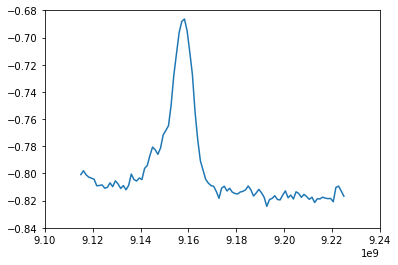

In [23]:
plt.plot(q_lo_freqs, angle(z_data))
q_lo_freqs[angle(z_data)==max(angle(z_data))]

# Two-tone spectroscopy with pulsed readout 

In [153]:
dso.set_offset(0, *Channel.ALL)

In [156]:
ro_pb.add_zero_pulse(1).add_dc_pulse(1000, 5)
ro_awg.output_pulse_sequence(ro_pb.build())

q_pb.add_dc_pulse(5000, 5)
q_awg.output_pulse_sequence(q_pb.build())

NameError: name 'ro_pb' is not defined

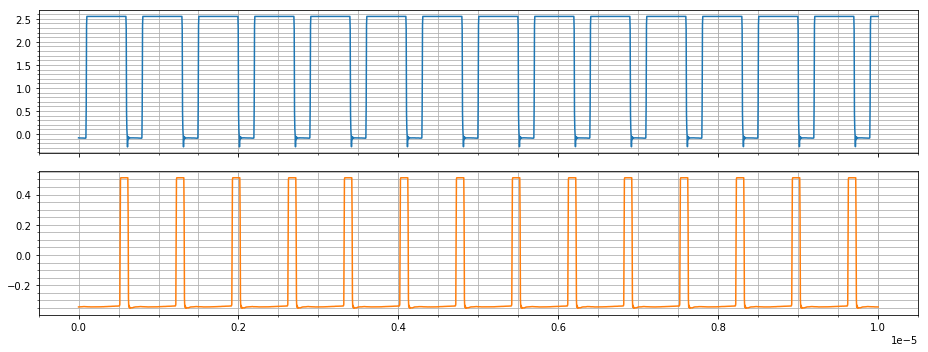

In [160]:
dso.set_time_range(10e-6)
dso.set_time_offset(1e-6)
dso.digitize()
times, channel_data = dso.get_data(Channel.ONE, Channel.TWO)
axes = flatten(plt.subplots(2,1, sharex=True, figsize=(13,5))[1])
colors = ["C0", "C1", "C2", "C3"]
for idx, ax in enumerate(axes):
    ax.plot(times, channel_data[idx], color=colors[idx])
    ax.minorticks_on()
    ax.grid(which="both")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

In [220]:
vna.set_averages(10)

True

In [50]:
z_data = []
for idx, freq in enumerate(q_lo_freqs):
    q_lo.set_frequency(freq)
    vna.prepare_for_stb()
    vna.sweep_single()
    vna.wait_for_stb()
    z_data.append(vna.get_sdata()[0])
    print("\r%.1f%%"%((idx+1)/len(q_lo_freqs)*100), end="")
z_data = array(z_data)

100.0%

array([  9.16388889e+09])

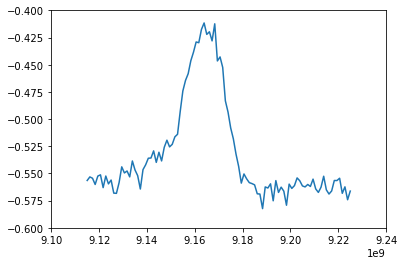

In [51]:
plt.plot(q_lo_freqs, angle(z_data))
q_lo_freqs[angle(z_data)==max(angle(z_data))]

# Two-tone spectroscopy with pulsed readout and excitation

In [24]:
ro_pb.add_zero_pulse(4000-400).add_dc_pulse(1000, 5).add_zero_pulse(200)
ro_awg.output_pulse_sequence(ro_pb.build())

q_pb.add_dc_pulse(3900, 5).add_zero_pulse(1200)
q_awg.output_pulse_sequence(q_pb.build())

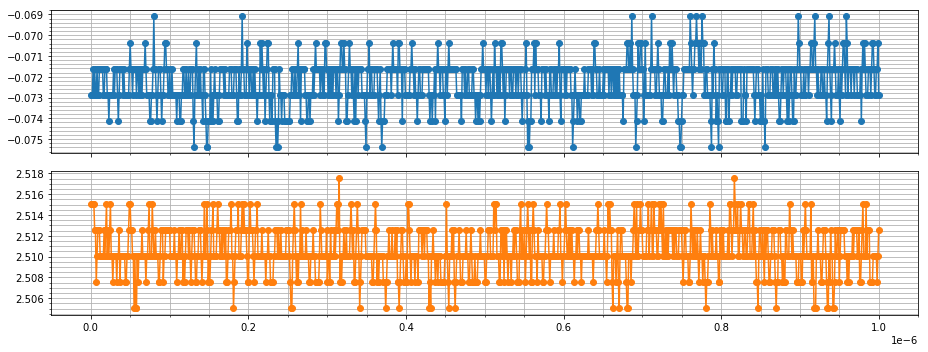

In [200]:
dso.set_time_range(1e-6)
dso.set_time_offset(.1e-6)
dso.digitize()
times, channel_data = dso.get_data(Channel.ONE, Channel.TWO)
axes = flatten(plt.subplots(2,1, sharex=True, figsize=(13,5))[1])
colors = ["C0", "C1", "C2", "C3"]
for idx, ax in enumerate(axes):
    ax.plot(times, channel_data[idx], "-o", color=colors[idx])
    ax.minorticks_on()
    ax.grid(which="both")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()
# plt.xlim(0.e-6, 1e-6)

In [34]:
z_data = []
for idx, freq in enumerate(q_lo_freqs):
    q_lo.set_frequency(freq)
    vna.prepare_for_stb()
    vna.sweep_single()
    vna.wait_for_stb()
    z_data.append(vna.get_sdata()[0])
    print("\r%.1f%%"%((idx+1)/len(q_lo_freqs)*100), end="")
z_data = array(z_data)

NameError: name 'q_lo_freqs' is not defined

array([  9.17388889e+09])

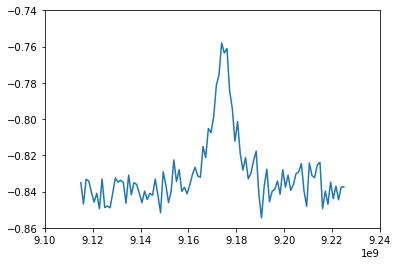

In [27]:
plt.plot(q_lo_freqs, angle(z_data))
q_lo_freqs[angle(z_data)==max(angle(z_data))]

# Rabi

In [87]:
long_trace = vna.get_sdata()

In [88]:
plot(angle(long_trace), ",")

In [63]:
from scipy.fftpack import fft

In [81]:
from pandas import DataFrame, rolling_mean

In [89]:
df = DataFrame(data = angle(long_trace))

In [100]:
part_trace = angle(long_trace)[:1000]
std(part_trace), mean(part_trace)

(0.033290955096767605, -0.82652712485962565)

In [101]:
rolling_mean(df,100).plot()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100,center=False).mean()
  if __name__ == '__main__':


In [103]:
plot(abs(fft(angle(vna.get_sdata()), n=2**20)), '.')
# xlim(0,1000)
yscale("log")
xscale("log")

In [ ]:
ru

#### Test sequence at time t

In [85]:
q_lo.set_output_state("ON")

In [47]:
q_pb._waveform_resolution=1
ro_pb._waveform_resolution=1

In [58]:
t=1000
def generate_pulses_rabi(t):
    q_pb.add_zero_pulse(400).add_dc_pulse(t, 5).add_zero_pulse(1000).add_zero_pulse(8000-1000-t-400)
    q_awg.output_pulse_sequence(q_pb.build())

    ro_pb.add_zero_pulse(t).add_dc_pulse(1000,5).add_zero_pulse(100)
    ro_awg.output_pulse_sequence(ro_pb.build())
generate_pulses_rabi(t)

In [16]:
dso.set_time_range(5e-6)
dso.set_time_offset(.5e-6)
dso.digitize()
times, channel_data = dso.get_data(Channel.ONE, Channel.TWO)
axes = flatten(plt.subplots(2,1, sharex=True, figsize=(13,5))[1])
colors = ["C0", "C1", "C2", "C3"]
for idx, ax in enumerate(axes):
    ax.plot(times, channel_data[idx], color=colors[idx])
    ax.minorticks_on()
    ax.grid(which="both")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

In [32]:
q_frequency = 9.174e9

In [104]:
vna.set_averages(5)
vna.set_bandwidth(20)
vna.set_nop(1000)

True

In [105]:
excitation_times = linspace(1, 2000, 100)
excitation_freqs = [q_frequency]#linspace(q_frequency-10e6, q_frequency+10e6, 50)#

start_time = dt.now()
print("Started at", start_time)

rabi_shevrons = []
phases = []
for i, excitation_freq in enumerate(excitation_freqs):
    q_lo.set_frequency(excitation_freq)
    z_data = []
    for j, t in enumerate(excitation_times):
        
        generate_pulses_rabi(t)
#         sleep(0.5)
        vna.avg_clear()
        vna.prepare_for_stb()
        vna.sweep_single()
        vna.wait_for_stb()
        s_data = vna.get_sdata()
        z_data.append(mean(s_data))
        phases.append(median(angle(s_data)))
        
        part_complete = (i*len(excitation_times)+j+1)/len(excitation_times)/len(excitation_freqs)
        elapsed_time = (dt.now() - start_time).total_seconds()
        time_left = format_time_delta(elapsed_time/part_complete-elapsed_time)
        cla()
        plot(excitation_times[:j+1], angle(z_data))
        plot(excitation_times[:j+1], phases)
        plt.pause(0.01)
        print("\r%.5f%% Time: %d ns, freq: %.5f GHz. Time left: %s    "%(part_complete*100, t,
                excitation_freq/1e9, time_left), end="")
    rabi_shevrons.append(z_data)
#     pcolormesh(angle(rabi_shevrons).T)
#     plt.pause(0.01)

rabi_shevrons = array(rabi_shevrons)

Started at 2017-04-08 20:54:45.348259


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backend_bases.py:2445: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


66.00000% Time: 1313 ns, freq: 9.17400 GHz. Time left: 2 h 5 m 50.32 s     

KeyboardInterrupt: 

In [42]:
pcolormesh(excitation_freqs, excitation_times, angle(rabi_shevrons).T-angle(rabi_shevrons[:,0]), cmap="RdBu_r")
# plt.gcf().set_size_inches(15,10)
plt.savefig("./data/Apr 7 2017/xmon_al_bmstu_1-I-rabi-shevrons.png")

In [39]:
import pickle

In [41]:
with open("./data/Apr 7 2017/xmon_al_bmstu_1-I-rabi-shevrons.pkl", "w+b") as f:
    pickle.dump((excitation_freqs, excitation_times, angle(rabi_shevrons).T), f)

In [222]:
def theoretical_rabi(t, A, gamma_R, Omega_R, offset):
    return A*exp(-gamma_R*t)*cos(Omega_R*t)+offset

In [245]:
opt_params = curve_fit(theoretical_rabi, excitation_times[:], angle(rabi_shevrons)[0][:], (.1, 1.5e-3, 5e-2, -0.96))[0]
opt_params

array([-0.07606654,  0.00174739,  0.0320381 , -1.06787685])

In [246]:
plot(excitation_times, angle(rabi_shevrons)[0])
plot(excitation_times, theoretical_rabi(excitation_times, *opt_params))
xlabel("Excitation time [ns]")
ylabel("VNA phase [rad]")
bbox_props = dict(boxstyle="round", fc="white", ec="black", lw=1)
annotate("$T_R=%.2f\ \mu$s\n$\Omega_R/2\pi = %.2f$ MHz"%(1/opt_params[1]/1e3, opt_params[2]*1e3/2/pi), (mean(gca().get_xlim()),  angle(rabi_shevrons)[0][0]), bbox=bbox_props, ha="center")

In [170]:
plt.savefig("./data/Apr 7 2017/xmon_al_bmstu_1-I-rabi-fit.png")

In [160]:
with open("./data/Apr 7 2017/xmon_al_bmstu_1-I-rabi-fit.pkl", "w+b") as f:
    pickle.dump((excitation_times, angle(rabi_shevrons)[0]), f)

In [109]:
plt.plot(angle(z_data))

In [106]:
plt.plot(excitation_times, angle(rabi_shevrons)[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

# Decay

In [116]:
t_pi = 90

In [117]:
delay = 5000
def generate_pulses(delay):
    q_pb.add_zero_pulse(400).add_dc_pulse(t_pi, 5).add_zero_pulse(1000).add_zero_pulse(10000-1000-t_pi-400)
    q_awg.output_pulse_sequence(q_pb.build())

    ro_pb.add_zero_pulse(t_pi+delay).add_dc_pulse(1000,5).add_zero_pulse(1)
    ro_awg.output_pulse_sequence(ro_pb.build())
generate_pulses(delay)

In [118]:
dso.set_time_range(15e-6)
dso.set_time_offset(1.5e-6)
dso.digitize()
times, channel_data = dso.get_data(Channel.ONE, Channel.TWO)
axes = flatten(plt.subplots(2,1, sharex=True, figsize=(13,5))[1])
colors = ["C0", "C1", "C2", "C3"]
for idx, ax in enumerate(axes):
    ax.plot(times, channel_data[idx], color=colors[idx])
    ax.minorticks_on()
    ax.grid(which="both")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

In [131]:
vna.set_averages(1)
vna.set_bandwidth(200)
vna.set_nop(10000)

True

Test phase with no qubit excitation:

In [51]:
q_lo.set_output_state("OFF")

phases = []
for i in range(0,10):
    vna.avg_clear()
    vna.prepare_for_stb()
    vna.sweep_single()
    vna.wait_for_stb()
    phases.append(vna.get_sdata()[0])
    plot(angle(phases))
    pause(0.01)
    print("\r%.2f%%"%(i), end="")
q_lo.set_output_state("ON")

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backend_bases.py:2445: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


9.00%

In [132]:
delays = linspace(0, 7500, 75)

start_time = dt.now()
print("Started at", start_time)

z_data = []
for j, delay in enumerate(delays):
    
    generate_pulses(delay)
    
    vna.avg_clear()
    vna.prepare_for_stb()
    vna.sweep_single()
    vna.wait_for_stb()
    z_data.append(median(angle(vna.get_sdata())))

    part_complete = (j+1)/len(delays)
    elapsed_time = (dt.now() - start_time).total_seconds()
    time_left = format_time_delta(elapsed_time/part_complete-elapsed_time)
    plt.cla()
    plot(delays[:j+1],z_data)
    plt.pause(0.01)
    print("\r%.5f%% Time: %d ns, freq: %.5f GHz. Time left: %s    "%(part_complete*100, delay,
            excitation_freq/1e9, time_left), end="")

z_data = array(z_data)

Started at 2017-04-07 18:15:57.030473


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backend_bases.py:2445: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


100.00000% Time: 7500 ns, freq: 9.17450 GHz. Time left: 0 h 0 m 0.0 s      

In [56]:
plot(delays, angle(z_data))

In [55]:
def theoretical_decay(t, gamma, A, offset):
    return A*exp(-gamma*t) + offset

In [54]:
from scipy.optimize import curve_fit

In [172]:
opt_params = curve_fit(theoretical_decay, delays[:], z_data[:], p0=(0.001, 1, -0.8))[0]

In [173]:
1/opt_params[0]

1739.5919885244557

In [177]:
plot(delays, z_data)
plot(delays, theoretical_decay(delays, *opt_params))
xlabel("Readout delay [ns]")
ylabel("VNA phase [rad]")
bbox_props = dict(boxstyle="round", fc="white", ec="black", lw=1)
annotate("$T_1=%.2f\ \mu$s"%(1/opt_params[0]/1e3), (mean(gca().get_xlim()), z_data[0]*1.01), bbox=bbox_props, ha="center")

In [178]:
plt.savefig("./data/Apr 7 2017/xmon_al_bmstu_1-I-decay-fit.png")

In [156]:
with open("./data/Apr 7 2017/xmon_al_bmstu_1-I-decay-fit.pkl", "w+b") as f:
    pickle.dump((delays, z_data), f)

In [33]:
mxg

NameError: name 'mxg' is not defined